In [196]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# import XGBRegressor
from xgboost import XGBRegressor
# import GridSearchCV
from sklearn.model_selection import GridSearchCV
# import mean_absolute_error
from sklearn.metrics import mean_absolute_error
# import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D

# load model
from keras.models import load_model

# pickle
import pickle

# import datatime
from datetime import datetime

# LinearRegression
from sklearn.linear_model import LinearRegression

# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# mtick
import matplotlib.ticker as mtick

# import timedelta
from datetime import timedelta


In [158]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_drop.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
# "자동차용 경유 가격 (원)" 만 사용
df = df[['자동차용 경유 가격 (원)']]
# "자동차용 경유 가격 (원)" 컬럼의 이름을 "경유 가격"으로 변경
df = df.rename(columns={'자동차용 경유 가격 (원)':'경유 가격'})
df

,경유 가격
거래년월일,
2000-01-03,583.35
2000-01-04,583.35
2000-01-05,583.35
2000-01-06,583.35
2000-01-07,583.35
...,...
2022-11-24,1879.15
2022-11-25,1879.15
2022-11-28,1879.15


In [159]:
# "경유 가격"의 이동평균을 함수로 만든다
def make_ma(df, col, ma_list):
    for ma in ma_list:
        df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean().shift(1)
    return df

# "경유 가격"의 이동평균을 만든다
df = make_ma(df, '경유 가격', [5, 10, 20, 60, 300])

# 컬럼의 결측치를 제거한다
df = df.dropna()
df

,경유 가격,경유 가격_5MA,경유 가격_10MA,경유 가격_20MA,경유 가격_60MA,경유 가격_300MA
거래년월일,,,,,,
2001-01-11,660.99,660.99,665.284,673.8720,682.983333,614.566967
2001-01-12,660.99,660.99,663.137,672.7985,682.463500,614.825767
2001-01-13,660.99,660.99,660.990,671.7250,681.981667,615.084567
2001-01-15,660.99,660.99,660.990,670.6515,681.499833,615.343367
2001-01-16,660.99,660.99,660.990,669.5780,681.018000,615.602167
...,...,...,...,...,...,...
2022-11-24,1879.15,1879.15,1879.150,1873.0285,1857.254167,1750.412400
2022-11-25,1879.15,1879.15,1879.150,1875.0690,1857.084833,1751.874433
2022-11-28,1879.15,1879.15,1879.150,1877.1095,1856.915500,1753.336467


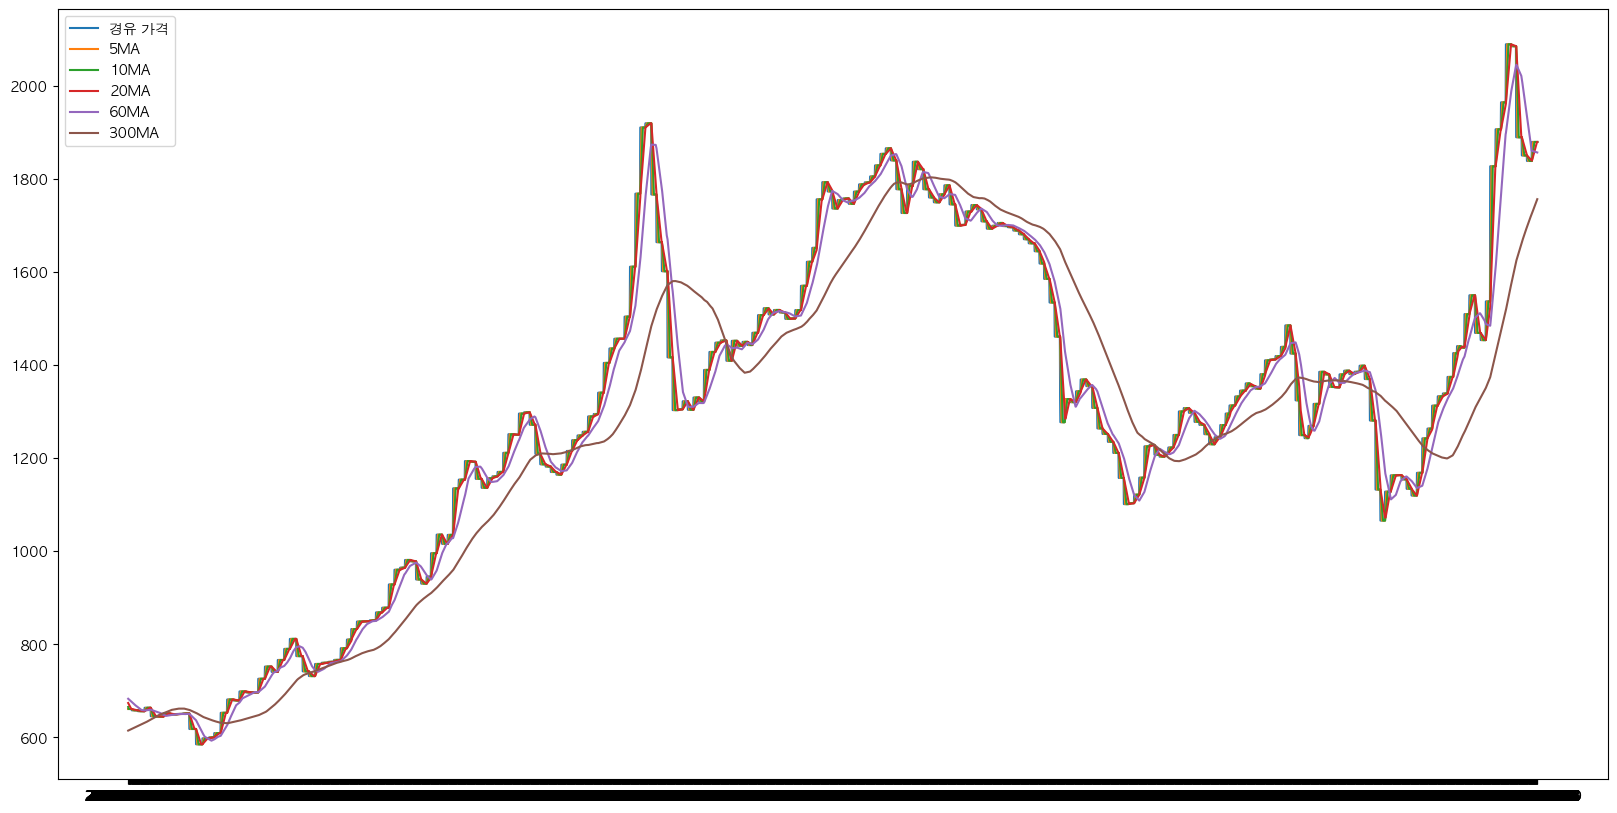

In [90]:
# "경유 가격"의 이동평균을 그래프로 확인한다
plt.figure(figsize=(20, 10))
plt.plot(df['경유 가격'], label='경유 가격')
plt.plot(df['경유 가격_5MA'], label='5MA')
plt.plot(df['경유 가격_10MA'], label='10MA')
plt.plot(df['경유 가격_20MA'], label='20MA')
plt.plot(df['경유 가격_60MA'], label='60MA')
plt.plot(df['경유 가격_300MA'], label='300MA')
plt.legend()
plt.show()


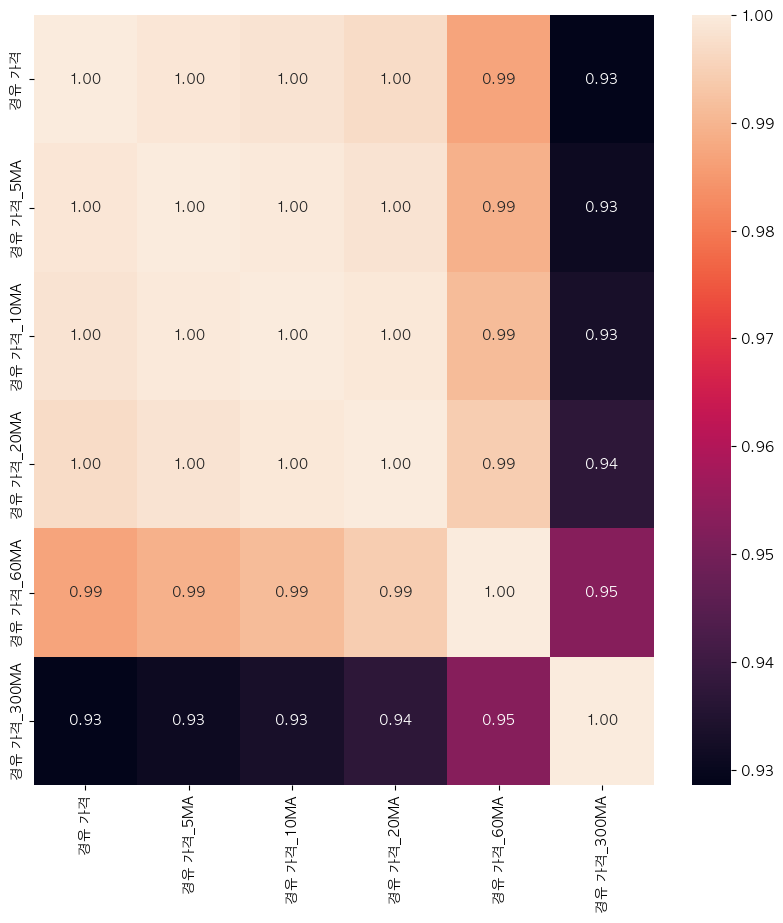

In [91]:
# 상관관계를 확인한다
df.corr()

# 상관관계 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

In [92]:
# 2022-11-01 을 기준으로 df를 나눈다
df_train = df[df.index < '2021-01-01']
df_test = df[df.index >= '2021-01-01']

In [203]:
df_test

,경유 가격,경유 가격_5MA,경유 가격_10MA,경유 가격_20MA,경유 가격_60MA,경유 가격_300MA
거래년월일,,,,,,
2021-01-04,1242.35,1168.320,1168.320,1168.3200,1140.960000,1227.045000
2021-01-05,1242.35,1183.126,1175.723,1172.0215,1142.766500,1226.560400
2021-01-06,1242.35,1197.932,1183.126,1175.7230,1144.573000,1226.075800
2021-01-07,1242.35,1212.738,1190.529,1179.4245,1146.379500,1225.591200
2021-01-08,1242.35,1227.544,1197.932,1183.1260,1148.186000,1225.106600
...,...,...,...,...,...,...
2022-11-24,1879.15,1879.150,1879.150,1873.0285,1857.254167,1750.412400
2022-11-25,1879.15,1879.150,1879.150,1875.0690,1857.084833,1751.874433
2022-11-28,1879.15,1879.150,1879.150,1877.1095,1856.915500,1753.336467


In [93]:
# "경유 가격" 이외에 컬럼을 사용하여 "경유 가격"을 예측한다
# "경유 가격_5MA", "경유 가격_10MA", "경유 가격_20MA", "경유 가격_60MA", "경유 가격_300MA" 컬럼을 X, "경유 가격" 컬럼을 y로 설정한다
X_train = df_train.drop('경유 가격', axis=1)
y_train = df_train['경유 가격']
X_test = df_test.drop('경유 가격', axis=1)
y_test = df_test['경유 가격']

In [94]:
#  데이터 전처리
# 데이터를 0과 1사이의 값으로 변환한다
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [95]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적의 하이퍼파라미터: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.7}
최고 예측 정확도: 0.2089


In [96]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [97]:
# XGBoost 모델을 평가한다
y_pred = xgb.predict(X_test)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

XGBoost 모델의 RMSE: 150.91371518568482


In [98]:
# 예측 성능 평가 지표를 출력한다
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

MAE: 116.58738707406181
MSE: 22774.949431146
RMSE: 150.91371518568482
R2: 0.6935128627925936


In [99]:
# 모델 저장
# 모델을 저장한다 model/
pickle.dump(xgb, open('model/xgb_oil.pkl', 'wb'))

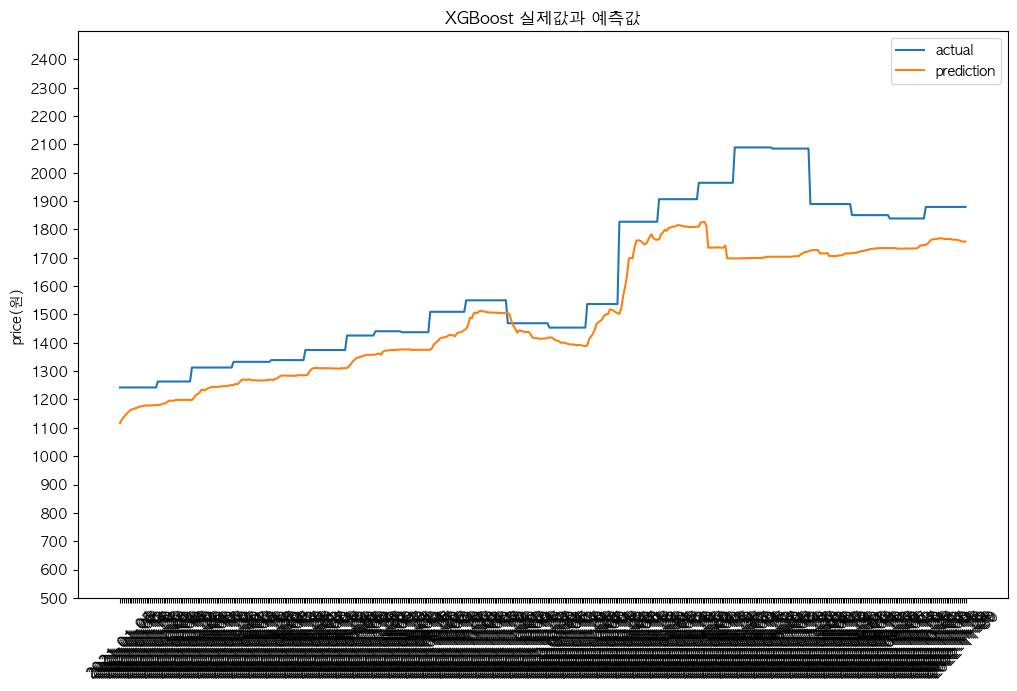

In [100]:

# XGBoost 모델의 예측 결과를 시각화한다 
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='actual')
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
# 글자 겹침을 방지하기 위해 하단에 간격을 둔다
plt.subplots_adjust(bottom=0.25)
plt.plot(y_pred, label='prediction')
plt.title('XGBoost 실제값과 예측값')
plt.ylim(500, 2500)
# y축의 눈금을 0부터 40000까지 1000 단위로 설정한다
plt.yticks(np.arange(500, 2500, 100))
# y축 눈금 라벨을 원 단위로 설정한다
plt.ylabel('price(원)')
plt.legend()
plt.show()

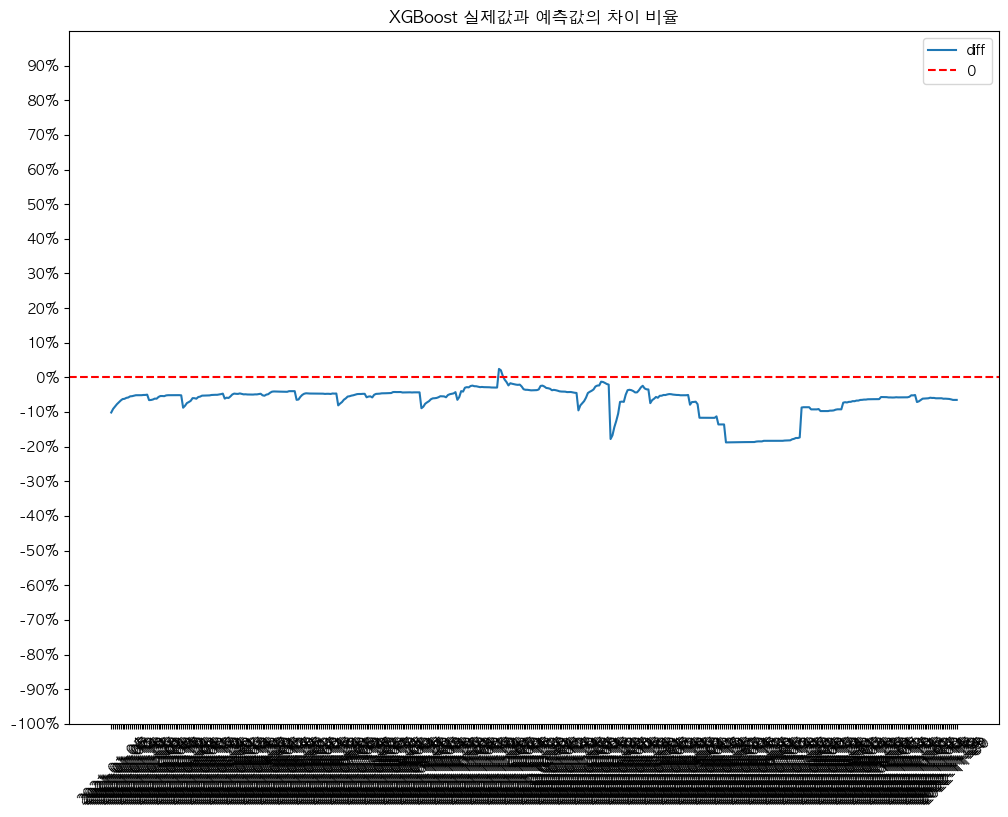

In [101]:
# 예측값 성능 평가
# 예측값과 실제값의 차이를 비율로 계산한다
diff = (y_pred - y_test) / y_test * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()

In [102]:
# 예측값과 실제값의 차이의 비율을 ratio에 저장한다
ratio = diff

# add_price 값을 구하는 모델을 학습한다
# 학습 데이터를 준비한다
X = ratio.values.reshape(-1, 1)
y = y_pred - y_test

# 선형 회귀 모델을 학습한다
lr = LinearRegression()
lr.fit(X, y)

# add_price 값을 예측한다
add_price = lr.predict([[0]])

# add_price 값을 출력한다
print('add_price:', add_price)

# add_price 값을 구하는 모델을 저장한다
pickle.dump(lr, open('model/lr_oil.pkl', 'wb'))

# add_price 값을 구하는 모델을 로드한다
lr = pickle.load(open('model/lr_oil.pkl', 'rb'))

# add_price 값을 예측한다
add_price = lr.predict([[0]])

# add_price 값을 출력한다
print('add_price:', add_price)


# ratio의 값이 0에 많이 분포 될 수 있도록 y_pred에 add_price 값을 더한다
y_pred = y_pred + add_price



add_price: [31.3537569]
add_price: [31.3537569]


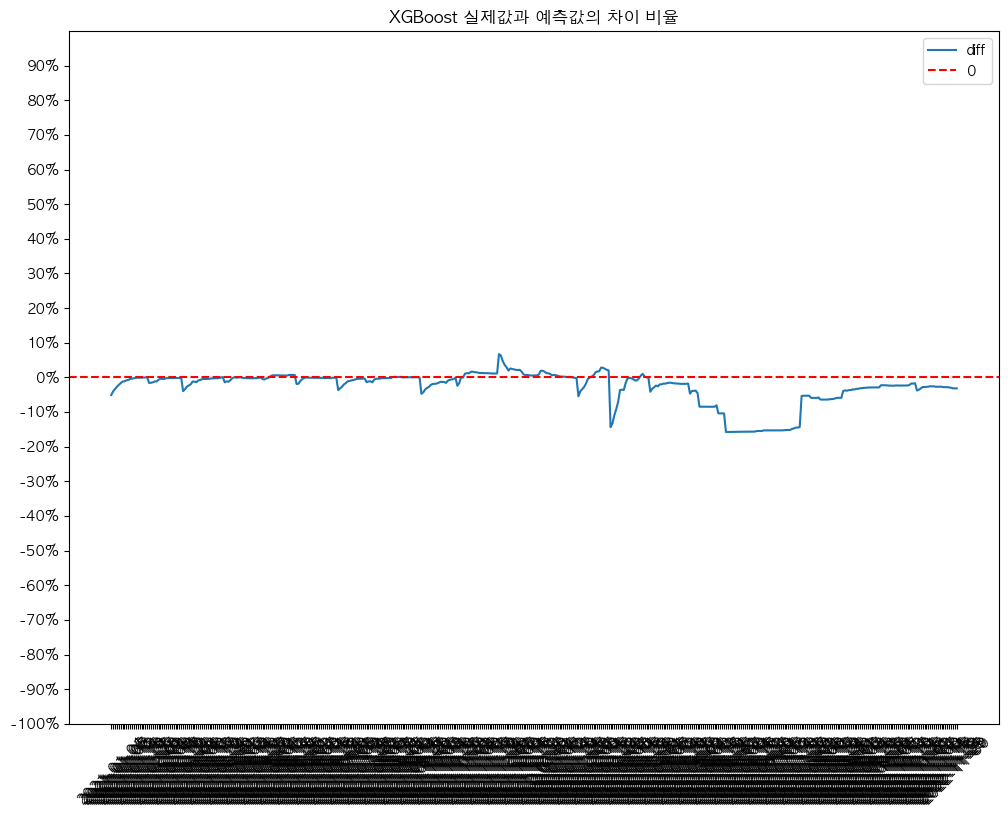

In [103]:
# ratio의 값이 0에 많이 분포 될 수 있도록 y_pred에 add_price 값을 더한다
y_pred = y_pred + add_price

# 예측값 성능 평가
# 예측값과 실제값의 차이를 비율로 계산한다
diff = (y_pred - y_test) / y_test * 100
diff = diff.dropna()

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()






In [187]:
#  예측값을 데이터프레임에 저장한다
df_pred = pd.DataFrame(y_pred, columns=['경유 예측 가격'], index=df_test.index)

# 인덱스를 타임스탬프로 변환한다
df_pred.index = pd.to_datetime(df_pred.index)

df_pred

,경유 예측 가격
거래년월일,
2021-01-04,1179.267694
2021-01-05,1192.261591
2021-01-06,1200.373285
2021-01-07,1209.027582
2021-01-08,1215.387812
...,...
2022-11-24,1825.147821
2022-11-25,1822.931513
2022-11-28,1819.884394


In [200]:
# 예측할 기간에 대한 날짜를 생성한다
date = pd.date_range(start='2022-11-01', end='2022-11-30')

# 예측할 기간에 대한 날짜를 데이터프레임에 저장한다
df_date = pd.DataFrame(date, columns=['거래년월일'])

# 예측할 기간에 대한 날짜를 인덱스로 설정한다
df_date = df_date.set_index('거래년월일')

# 주말 날짜를 제외한다
df_date = df_date[~df_date.index.dayofweek.isin([3,4])]

# 컬럼 생성 ("경유 가격","경유 가격_5MA","경유 가격_10MA","경유 가격_20MA","경유 가격_60MA","경유 가격_300MA")
df_date['경유 예측 가격'] = 0
df_date['경유 가격_5MA'] = 0
df_date['경유 가격_10MA'] = 0
df_date['경유 가격_20MA'] = 0
df_date['경유 가격_60MA'] = 0
df_date['경유 가격_300MA'] = 0

df_date


,경유 예측 가격,경유 가격_5MA,경유 가격_10MA,경유 가격_20MA,경유 가격_60MA,경유 가격_300MA
거래년월일,,,,,,
2022-11-01,0,0,0,0,0,0
2022-11-02,0,0,0,0,0,0
2022-11-05,0,0,0,0,0,0
2022-11-06,0,0,0,0,0,0
2022-11-07,0,0,0,0,0,0
2022-11-08,0,0,0,0,0,0
2022-11-09,0,0,0,0,0,0
2022-11-12,0,0,0,0,0,0
2022-11-13,0,0,0,0,0,0


In [201]:
# df_pred와 df_date를 합친다 df_pred 기준으로 합친다 left join
df_merge = pd.merge(df_pred, df_date, how='left', left_index=True, right_index=True)

df_merge = df_merge[df_merge.index >= '2022-11-01']

# 컬럼명을 변경한다
df_merge = df_merge.rename(columns={'경유 예측 가격_x':'경유 예측 가격'})

# 컬럼을 삭제한다
df_merge = df_merge.drop(['경유 예측 가격_y'], axis=1)

# df_merge의 결측치를 0으로 채운다
df_merge = df_merge.fillna(0)

df_merge

,경유 예측 가격,경유 가격_5MA,경유 가격_10MA,경유 가격_20MA,경유 가격_60MA,경유 가격_300MA
거래년월일,,,,,,
2022-11-01,1808.313715,0.0,0.0,0.0,0.0,0.0
2022-11-02,1812.237421,0.0,0.0,0.0,0.0,0.0
2022-11-03,1819.605829,0.0,0.0,0.0,0.0,0.0
2022-11-04,1826.658686,0.0,0.0,0.0,0.0,0.0
2022-11-07,1827.484491,0.0,0.0,0.0,0.0,0.0
2022-11-08,1828.533686,0.0,0.0,0.0,0.0,0.0
2022-11-09,1828.658197,0.0,0.0,0.0,0.0,0.0
2022-11-10,1831.787958,0.0,0.0,0.0,0.0,0.0
2022-11-11,1830.432489,0.0,0.0,0.0,0.0,0.0


In [202]:
df_all = df.copy()
# df_all 데이터를 사용하여 df_merge 값을 채운다

# # df_merge의 "2022-11-01" 인덱스의 경유 가격_5MA 컬럼 값은 df_all의 해당 날짜를 제외한 5일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-01', '경유 가격_5MA'] = df_all.loc['2022-10-25':'2022-10-28', '경유 가격'].mean()

# # df_merge의 "2022-11-01" 인덱스의 경유 가격_10MA 컬럼 값은 df_all의 해당 날짜를 제외한 10일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-01', '경유 가격_10MA'] = df_all.loc['2022-10-20':'2022-10-28', '경유 가격'].mean()

# # df_merge의 "2022-11-01" 인덱스의 경유 가격_20MA 컬럼 값은 df_all의 해당 날짜를 제외한 20일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-01', '경유 가격_20MA'] = df_all.loc['2022-10-10':'2022-10-28', '경유 가격'].mean()

# # df_merge의 "2022-11-01" 인덱스의 경유 가격_60MA 컬럼 값은 df_all의 해당 날짜를 제외한 60일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-01', '경유 가격_60MA'] = df_all.loc['2022-09-01':'2022-10-28', '경유 가격'].mean()

# # df_merge의 "2022-11-01" 인덱스의 경유 가격_300MA 컬럼 값은 df_all의 해당 날짜를 제외한 300일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-01', '경유 가격_300MA'] = df_all.loc['2021-11-01':'2022-10-28', '경유 가격'].mean()

# # df_merge의 "2022-11-02" 인덱스의 경유 가격_5MA 컬럼 값은 df_all의 해당 날짜를 제외한 5일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-02', '경유 가격_5MA'] = df_all.loc['2022-10-26':'2022-10-29', '경유 가격'].mean()

# # df_merge의 "2022-11-02" 인덱스의 경유 가격_10MA 컬럼 값은 df_all의 해당 날짜를 제외한 10일 이전 날짜 동안의 경유 가격의 평균값으로 채운다
# df_merge.loc['2022-11-02', '경유 가격_10MA'] = df_all.loc['2022-10-21':'2022-10-29', '경유 가격'].mean()

# 위의 코드를 반복문 함수로 만들어서 실행한다
for i in range(1, 31):
    df_merge.loc[f'2022-11-{i:02}', '경유 가격_5MA'] = df_all.loc[f'2022-10-{i+24:02}':f'2022-10-{i+27:02}', '경유 가격'].mean()
    df_merge.loc[f'2022-11-{i:02}', '경유 가격_10MA'] = df_all.loc[f'2022-10-{i+19:02}':f'2022-10-{i+27:02}', '경유 가격'].mean()
    df_merge.loc[f'2022-11-{i:02}', '경유 가격_20MA'] = df_all.loc[f'2022-10-{i+9:02}':f'2022-10-{i+27:02}', '경유 가격'].mean()
    df_merge.loc[f'2022-11-{i:02}', '경유 가격_60MA'] = df_all.loc[f'2022-09-{i:02}':f'2022-10-{i+27:02}', '경유 가격'].mean()
    df_merge.loc[f'2022-11-{i:02}', '경유 가격_300MA'] = df_all.loc[f'2021-11-{i:02}':f'2022-10-{i+27:02}', '경유 가격'].mean()





In [199]:
df_merge

,경유 예측 가격,경유 가격_5MA,경유 가격_10MA,경유 가격_20MA,경유 가격_60MA,경유 가격_300MA
거래년월일,,,,,,
2022-11-01,1808.313715,1838.34,1838.34,1838.34,1844.582105,1787.035248
2022-11-02,1812.237421,1838.34,1838.34,1838.34,1844.430270,1788.019959
2022-11-03,1819.605829,1838.34,1838.34,1838.34,1844.270000,1789.012875
2022-11-04,1826.658686,1838.34,1838.34,1838.34,1844.109730,1790.215458
2022-11-07,1827.484491,1838.34,1838.34,1838.34,1843.761714,1792.236429
2022-11-08,1828.533686,NaN,1838.34,1838.34,1843.572353,1792.236429
2022-11-09,1828.658197,NaN,1838.34,1838.34,1843.371515,1793.259705
2022-11-10,1831.787958,NaN,1838.34,1838.34,1843.371515,1794.291653
2022-11-11,1830.432489,NaN,1838.34,1838.34,1843.371515,1795.332383
